<a href="https://www.kaggle.com/code/jaimemorillo/profile-based-retrieval?scriptVersionId=91531504" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import random

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import label_binarize, LabelEncoder

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")
sns.set_style("ticks")
sns.set_context("notebook")

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from tqdm.notebook import tqdm
tqdm.pandas()

In [2]:
column_selected = 'headline' # choose short_description or headline
classes = ['POLITICS', 'WELLNESS', 'ENTERTAINMENT', 'TRAVEL', 'SPORTS']
df = pd.read_json('../input/news-category-dataset/News_Category_Dataset_v2.json', lines=True)
df = df[[column_selected, 'category']]
df = df[df['category'].isin(classes)]
df.category.value_counts()

POLITICS         32739
WELLNESS         17827
ENTERTAINMENT    16058
TRAVEL            9887
SPORTS            4884
Name: category, dtype: int64

In [3]:
df.tail(5)

,headline,category
200839,'Girl With the Dragon Tattoo' India Release Ca...,ENTERTAINMENT
200849,Maria Sharapova Stunned By Victoria Azarenka I...,SPORTS
200850,"Giants Over Patriots, Jets Over Colts Among M...",SPORTS
200851,Aldon Smith Arrested: 49ers Linebacker Busted ...,SPORTS
200852,Dwight Howard Rips Teammates After Magic Loss ...,SPORTS


Encode labels

In [4]:
le = LabelEncoder()
df['category'] = le.fit_transform(df.category)
classes = list(le.classes_)

#### Number of words

count    81395.00
mean         9.59
std          3.12
min          1.00
25%          7.00
50%         10.00
75%         12.00
max         44.00
Name: headline, dtype: float64


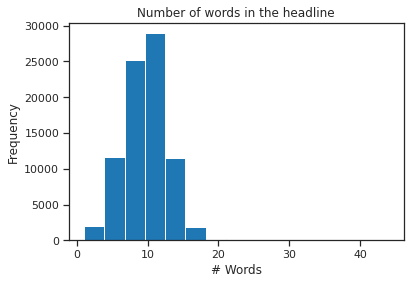

In [5]:
word_lens = df[column_selected].str.split(" ").str.len()
ax = word_lens.plot(kind='hist', bins=15, title='Number of words in the ' + column_selected)
ax.set_xlabel("# Words")
print(word_lens.describe().round(2))

In [6]:
df_final = df.copy()

# Normalize text
- Lower-case text.
- Replacing contractions.
- Cleaning up special characters.
- Removing extra whitespaces.
- Removing stopwords.
- Stemming.

In [7]:
class Normalizer:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.ps = PorterStemmer() # Create Stemmer
        self.word_net = WordNetLemmatizer() #Create Lemmatizer
    
    def remove_punct(self, text):
        text = text.lower() # To lower case
        # Replace contractions
        text = re.sub(r"\'s", " is ", text)
        text = re.sub(r"\'ve", " have ", text)
        text = re.sub(r"can't", "can not ", text)
        text = re.sub(r"n't", " not ", text)
        text = re.sub(r"i'm", "i am ", text)
        text = re.sub(r"\'re", " are ", text)
        text = re.sub(r"\'d", " would ", text)
        text = re.sub(r"\'ll", " will ", text)
        text = re.sub('\W', ' ', text) # Replace any character which is not a word character
        text = re.sub('\s+', ' ', text) # Replace any whitespace character
        text = re.sub(' +', ' ', text) # Replace multiple whitespaces
        text = text.strip() # Delete sorrounding whitespaces
        return text
    
    def tokenize(self, text):
        return word_tokenize(text)
    
    def remove_stop_words(self, tokens):
        return [word for word in tokens if not word in self.stop_words] 
    
    def stemming(self, tokens):
        return [ps.stem(word) for word in tokens]
    
    def lemmatize(self, tokens):
        return [self.word_net.lemmatize(word) for word in tokens]
    
    def return_sentences(self, tokens):
        return " ".join(tokens)
    
    def clean_all(self, text):
        text = self.remove_punct(text)
        tokens = self.tokenize(text)
        tokens = self.remove_stop_words(tokens)
        tokens = self.lemmatize(tokens)
        text = self.return_sentences(tokens)
        return text

In [8]:
norm = Normalizer()
df_final[column_selected] = df_final[column_selected].progress_apply(lambda x: norm.clean_all(x))

  0%|          | 0/81395 [00:00<?, ?it/s]

In [9]:
print('Original: ' + df[column_selected].iloc[50])
print('New: ' + df_final[column_selected].iloc[50])

Original: Trump Abruptly Cancels North Korea Summit With Kim Jong Un
New: trump abruptly cancel north korea summit kim jong un


Split in train (80%) and test (20%):

In [10]:
X = df_final[column_selected]
y = df_final.category

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9, stratify=y)
print(X_train.shape)
print(X_test.shape)

(65116,)
(16279,)


### TF-IDF

Apply Tf-Idf strategy to encode the text:

In [11]:
# Ignore words that appear in less than 10 document and more than 80% of the documents
tfidf = TfidfVectorizer(max_df=0.8, min_df=10)
X_train_enc = tfidf.fit_transform(X_train)
X_test_enc = tfidf.transform(X_test)

print('Vocabulary: ' + str(X_train_enc.shape[1]))
print('Original: ' + X_train.iloc[0])
print('Encoded: ' + str(X_train_enc[0]))

Vocabulary: 5910
Original: mueller threatened subpoena trump lawyer refused sit interview
Encoded:   (0, 2751)	0.2995407895110241
  (0, 4861)	0.39155313933126545
  (0, 4349)	0.4206528832271136
  (0, 3046)	0.31529782035377196
  (0, 5511)	0.14287966496142335
  (0, 5132)	0.4206528832271136
  (0, 5358)	0.40562213941864717
  (0, 3537)	0.344539002144151


In [12]:
param_grid = { 
    'penalty': ['l1', 'l2'],
    'loss' : ['hinge', 'squared_hinge'],
    'C': np.arange(0.1, 1.1, 0.1),
    'class_weight': ['balanced']
}

svc = LinearSVC(random_state=9)
# Stratified Kfold by default (cv)
clf = GridSearchCV(estimator=svc, param_grid=param_grid, cv= 5,
                   scoring='balanced_accuracy', refit=True,
                   return_train_score=False, n_jobs=-1, verbose=1)
clf.fit(X_train_enc, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
100 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/svm/_classes.py", line 272, in fit
    sample_weight=sample_weight,
  File "/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py", line 1185, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "/opt/co

GridSearchCV(cv=5, estimator=LinearSVC(random_state=9), n_jobs=-1,
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'class_weight': ['balanced'],
                         'loss': ['hinge', 'squared_hinge'],
                         'penalty': ['l1', 'l2']},
             scoring='balanced_accuracy', verbose=1)

In [13]:
pd.DataFrame(clf.cv_results_).sort_values('rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_loss,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,1.425420,0.007436,0.006857,0.000167,0.3,balanced,squared_hinge,l2,"{'C': 0.30000000000000004, 'class_weight': 'ba...",0.856854,0.855061,0.856449,0.855871,0.855914,0.856030,0.000605,1
7,1.281395,0.019664,0.006175,0.000203,0.2,balanced,squared_hinge,l2,"{'C': 0.2, 'class_weight': 'balanced', 'loss':...",0.856540,0.855983,0.856505,0.854540,0.855119,0.855737,0.000789,2
21,2.612029,0.182934,0.006793,0.000276,0.6,balanced,hinge,l2,"{'C': 0.6, 'class_weight': 'balanced', 'loss':...",0.856698,0.853834,0.855113,0.855454,0.855428,0.855305,0.000914,3
25,3.020574,0.308965,0.006967,0.000275,0.7,balanced,hinge,l2,"{'C': 0.7000000000000001, 'class_weight': 'bal...",0.856576,0.854197,0.852950,0.856099,0.855468,0.855058,0.001322,4
29,3.111706,0.137769,0.006607,0.000268,0.8,balanced,hinge,l2,"{'C': 0.8, 'class_weight': 'balanced', 'loss':...",0.857673,0.854546,0.853803,0.854790,0.854143,0.854991,0.001383,5


In [14]:
print(clf.best_score_)
print(clf.best_params_)

0.8560299039267771
{'C': 0.30000000000000004, 'class_weight': 'balanced', 'loss': 'squared_hinge', 'penalty': 'l2'}


In [15]:
predictions = clf.predict(X_test_enc)
print(accuracy_score(y_test, predictions))
print(balanced_accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

0.8778180477916334
0.8563275599059541
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      3212
           1       0.94      0.91      0.92      6548
           2       0.76      0.79      0.77       977
           3       0.83      0.85      0.84      1977
           4       0.84      0.88      0.86      3565

    accuracy                           0.88     16279
   macro avg       0.85      0.86      0.85     16279
weighted avg       0.88      0.88      0.88     16279



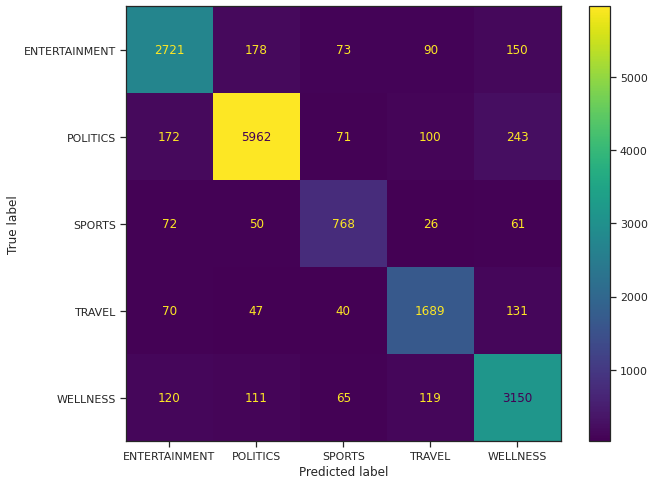

In [16]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 8))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, predictions),
    display_labels=classes)
cmp.plot(ax=ax)
plt.show()

# Users

In [17]:
class Users:
    def __init__(self, n_users, classes):
        self.users = self.create_users(n_users, classes)
        
    def create_users(self, n_users, classes):
        users = [('user_' + str(i), random.sample(classes, 
                                                  random.randint(1,4))) for i in range(1, n_users + 1)]
        return dict(users)
    
    def get_preferences(self, user_name):
        return self.users[user_name]
    
    def get_users_names(self):
        return list(self.users.keys())
    
    def get_items(self):
        return self.users.items()

In [18]:
my_users = Users(10, classes)

In [19]:
def random_sample_news(news, news_enc, targets, n_news=10):
    idx = np.random.choice(np.arange(news_enc.shape[0]), n_news, replace=False)
    x_sample = news.iloc[idx]
    x_enc_sample = news_enc[idx]
    y_sample = targets.iloc[idx]
    
    return np.array(x_sample), x_enc_sample, np.array(y_sample)

x_sample, x_enc_sample, y_sample = random_sample_news(X_test, X_test_enc, y_test, n_news=10)

In [20]:
def deliver_new(new, new_enc, users, classes, clf):
    print(new)
    idx = clf.predict(new_enc)[0]
    class_new = classes[idx]
    
    for k,v in my_users.get_items():
        if class_new in v:
            print('New deliver to: ' + k)

In [21]:
print(x_sample[0])
print(x_enc_sample[0])
print(classes[y_sample[0]])

mariah carey billionaire fiancé james packer reportedly split update
  (0, 5600)	0.3168525951337385
  (0, 5000)	0.3514556150007346
  (0, 4414)	0.30633064223625545
  (0, 3818)	0.4161261262949057
  (0, 3280)	0.38301242058617324
  (0, 2807)	0.2867909458564531
  (0, 854)	0.3772207779958688
  (0, 602)	0.3712692984654975
ENTERTAINMENT


In [22]:
my_users.users

{'user_1': ['ENTERTAINMENT', 'SPORTS', 'TRAVEL'],
 'user_2': ['POLITICS'],
 'user_3': ['WELLNESS', 'POLITICS'],
 'user_4': ['ENTERTAINMENT', 'TRAVEL', 'POLITICS', 'SPORTS'],
 'user_5': ['POLITICS'],
 'user_6': ['WELLNESS', 'SPORTS', 'ENTERTAINMENT'],
 'user_7': ['SPORTS'],
 'user_8': ['POLITICS', 'TRAVEL', 'SPORTS', 'WELLNESS'],
 'user_9': ['POLITICS', 'ENTERTAINMENT', 'SPORTS', 'TRAVEL'],
 'user_10': ['TRAVEL']}

In [23]:
deliver_new(x_sample[0], x_enc_sample[0], my_users, classes, clf)

mariah carey billionaire fiancé james packer reportedly split update
New deliver to: user_1
New deliver to: user_4
New deliver to: user_6
New deliver to: user_9


# ROC CURVES

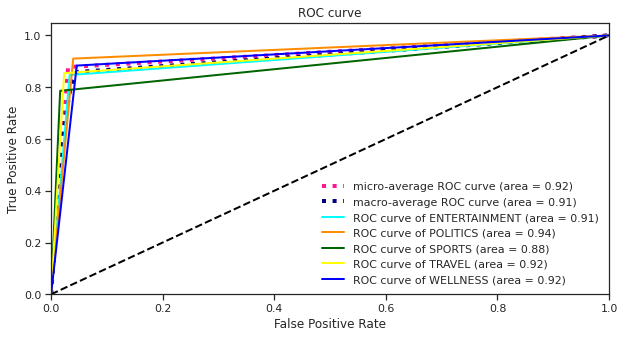

In [24]:
def plot_roc_curve(y_test, y_pred, classes):
    n_classes = len(classes)
    y_test = label_binarize(y_test, classes=np.arange(n_classes))
    y_pred = label_binarize(y_pred, classes=np.arange(n_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
  
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(10,5))
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"],
             label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
             color="deeppink", linestyle=":", linewidth=4,)

    plt.plot(fpr["macro"], tpr["macro"],
             label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
             color="navy", linestyle=":", linewidth=4,)

    colors = ["aqua", "darkorange", "darkgreen", "yellow", "blue"]
    for i, color in enumerate(colors):
        type_class = classes[i]
        plt.plot(fpr[i], tpr[i], color=color, lw=lw, 
                 label="ROC curve of " + type_class +" (area = {1:0.2f})".format(i, roc_auc[i]),)

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve")
    plt.legend()

plot_roc_curve(y_test, predictions, classes)